# Aggregation: Quantile

This notebook explains techniques for releasing differentially private quantiles.
Unlike counts and sums, the quantile can change by a large amount when one person contributes their data.

In [1]:
from statistics import median

# Given bounds of 0 and 100...
L, U = 0, 100

# ...and elements of x are at the bounds...
x = [L, U] * 50

# ...the median changes from 50 to 100 when one individual is added
median(x), median(x + [U])

(50.0, 100)

Even when the datasets are always non-empty, 
the sensitivity of $(U - L) / 2$ is too large for additive noise mechanisms to be suitable for estimating quantiles.

Instead of using this dataset of extremes, 
we'll demonstrate differentially private techniques with a more realistic skewed dataset sampled from $\mathrm{Exponential}(\lambda=20)$.

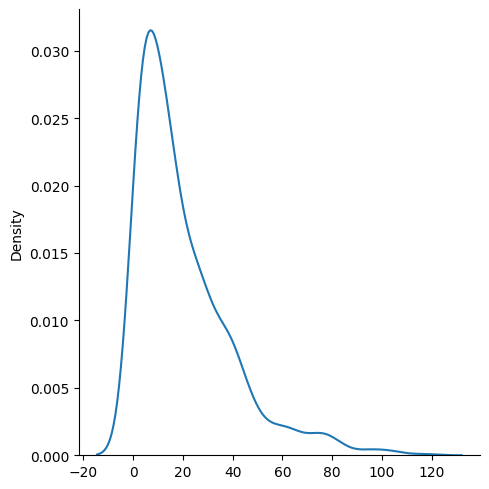

In [2]:
# privacy settings for all examples:
max_contributions = 1
epsilon = 1.

import numpy as np
data = np.random.exponential(20., size=1000)
bounds = 0, 100 # a best guess!

import seaborn as sns
sns.displot(data, kind="kde");

In [3]:
# true quantiles
quartiles = [0.25, 0.5, 0.75]
true_quantiles = np.quantile(data, quartiles)
true_quantiles.tolist()


[6.017448283972746, 14.352788448693698, 28.492092676514485]

----

Any constructors that have not completed the proof-writing and vetting process may still be accessed if you opt-in to "contrib".
Please contact us if you are interested in proof-writing. Thank you!

In [4]:
import opendp.prelude as dp
dp.enable_features("contrib")

## Quantile via Exponential Mechanism

Individual quantiles can be estimated via `private_quantile`, which uses the exponential mechanism.

In [5]:
context = dp.Context.compositor(
    data=data,
    privacy_unit=dp.unit_of(contributions=1),
    privacy_loss=dp.loss_of(epsilon=1.),
    split_evenly_over=3,
)

candidates = list(range(*bounds))

def release_quantile(alpha):
    query = context.query().drop_null().private_quantile(candidates, alpha)
    return query.release()

[release_quantile(alpha) for alpha in quartiles]

[6.0, 14.0, 29.0]

This is equivalent to the following, in the lower-level framework API:

In [6]:
input_space = dp.vector_domain(dp.atom_domain(T=float)), dp.symmetric_distance()


def make_expo_quantiles(alphas, d_in, d_out):
    t_pre = dp.t.make_drop_null(*input_space)
    def make_from_scale(scale):
        return dp.c.make_basic_composition([
            dp.m.make_private_quantile(*t_pre.output_space, candidates, alpha, scale)
            for alpha in alphas
        ])
    return dp.binary_search_chain(make_from_scale, d_in=d_in, d_out=d_out)


m_expo_quantile = make_expo_quantiles(quartiles, d_in=1, d_out=1.)
m_expo_quantile(data)

[6.0, 14.0, 29.0]

## Quantile via Histogram

Estimating the cumulative distribution function (CDF) performs better than 
releasing individual quantiles when you want to release a large number of quantiles.
The CDF can be estimated by simply releasing a histogram.

The basic procedure for estimating an $\alpha$-quantile is as follows:

1. bin the data, and count the number of elements in each bin privately
2. divide the counts by the total to get the probability density of landing in each bin
3. sum the densities while scanning from the left until the sum is at least $\alpha$
4. interpolate the bin edges of the terminal bin

In [7]:
def make_hist_quantiles(alphas, d_in, d_out, num_bins=500):

    edges = np.linspace(*bounds, num=num_bins + 1)
    bin_names = [str(i) for i in range(num_bins)]

    def make_from_scale(scale):
        return (
            input_space >>
            dp.t.then_drop_null() >>
            dp.t.then_find_bin(edges=edges) >> # bin the data
            dp.t.then_index(bin_names, "0") >> # can be omitted. Just set TIA="usize", categories=list(range(num_bins)) on next line:
            dp.t.then_count_by_categories(categories=bin_names, null_category=False) >>
            dp.m.then_laplace(scale) >>
            # we're really only interested in the function on this transformation- the domain and metric don't matter
            dp.t.make_cast_default(dp.vector_domain(dp.atom_domain(T=int)), dp.symmetric_distance(), TOA=float) >>
            dp.t.make_quantiles_from_counts(edges, alphas=alphas)
        )

    return dp.binary_search_chain(make_from_scale, d_in, d_out)

hist_quartiles_meas = make_hist_quantiles(quartiles, max_contributions, epsilon)
hist_quartiles_meas(data)


[6.5125, 14.833333333333334, 28.225]

A drawback of using this algorithm is that it can be difficult to choose the number of bins.

If the number of bins is chosen to be very small, then the postprocessor will need to sum fewer instances of noise before reaching the bin of interest, resulting in a better bin selection.
However, the bin will be wider, so there will be greater error when interpolating the final answer.

If the number of bins is chosen to be very large, then the same holds in the other direction.

Estimating quantiles via the next algorithm can help make choosing the number of bins less sensitive.


## Quantile via B-ary Tree

A slightly more complicated algorithm that tends to provide better utility is to privatize a B-ary tree instead of a histogram.
In this algorithm, the raw counts form the leaf nodes, and a complete tree is constructed by recursively summing groups of size `b`.
This results in a structure where each parent node is the sum of its `b` children.
Noise is added to each node in the tree, and then a postprocessor makes all nodes of the tree consistent with each other, and returns the leaf nodes.

In the histogram approach, the postprocessor would be influenced by a number of noise sources approximately $O(n)$ in the number of scanned bins.
After this modification, the postprocessor is influenced by a number of noise sources approximately $O(log_b(n))$ in the number of scanned bins, and with noise sources of similarly greater magnitude.

This modification introduces a new hyperparameter, the branching factor.
`choose_branching_factor` provides a heuristic for the ideal branching factor, based on information (or a best guess) of the dataset size.

In [8]:
b = dp.t.choose_branching_factor(size_guess=1_500)
b

25


We now make the following adjustments to the histogram algorithm:

* insert a stable (Lipschitz) transformation to construct a b-ary tree before the noise mechanism
* replace the cast postprocessor with a consistency postprocessor


In [9]:
def make_tree_quantiles(alphas, b, d_in, d_out, num_bins=500):

    edges = np.linspace(*bounds, num=num_bins + 1)
    bin_names = [str(i) for i in range(num_bins)]

    def make_from_scale(scale):
        return (
            input_space >>
            dp.t.then_drop_null() >>
            dp.t.then_find_bin(edges=edges) >> # bin the data
            dp.t.then_index(bin_names, "0") >> # can be omitted. Just set TIA="usize", categories=list(range(num_bins)) on next line:
            dp.t.then_count_by_categories(categories=bin_names, null_category=False) >>
            dp.t.then_b_ary_tree(leaf_count=len(bin_names), branching_factor=b) >>
            dp.m.then_laplace(scale) >> 
            dp.t.make_consistent_b_ary_tree(branching_factor=b) >>  # postprocessing
            dp.t.make_quantiles_from_counts(edges, alphas=alphas)   # postprocessing
        )

    return dp.binary_search_chain(make_from_scale, d_in, d_out)

tree_quartiles_meas = make_tree_quantiles(quartiles, b, max_contributions, epsilon)
tree_quartiles_meas(data)

[5.776087531830532, 13.692823991994207, 27.919560305444087]

As mentioned earlier, using the tree-based approach can help make the algorithm less sensitive to the number of bins:

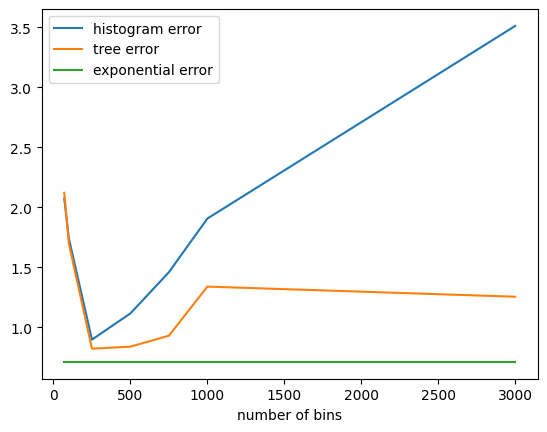

In [10]:
def sample_error(meas):
    return np.linalg.norm(true_quantiles - meas(data))

m_expo_quantiles = make_expo_quantiles(quartiles, max_contributions, epsilon)
expo_err = np.mean([sample_error(m_expo_quantiles) for _ in range(25)])

def average_error(num_bins, num_trials):
    m_hist_quantiles = make_hist_quantiles(quartiles, max_contributions, epsilon, num_bins)
    m_tree_quantiles = make_tree_quantiles(quartiles, b, max_contributions, epsilon, num_bins)

    hist_err = np.mean([sample_error(m_hist_quantiles) for _ in range(num_trials)])
    tree_err = np.mean([sample_error(m_tree_quantiles) for _ in range(num_trials)])

    return num_bins, hist_err, tree_err, expo_err

import pandas as pd
pd.DataFrame(
    [average_error(nb, num_trials=25) for nb in [70, 100, 250, 500, 750, 1_000, 3_000]],
    columns=["number of bins", "histogram error", "tree error", "exponential error"]
).plot(0); # type: ignore

The exponential mechanism is only evaluated once, as it runs independently of the number of bins as an argument.

The tree mechanism is more robust to the setting of the number of bins. 
In the case of the histogram, as the number of bins grows, the noise dominates the utility.

Of the three approaches, when only estimating three quantiles, the exponential mechanism performs the best.
However, the error will increase in the number of estimated quantiles more rapidly for the exponential mechanism than in the CDF-based mechanisms.

## Privately Estimating the Distribution

Minor note: instead of postprocessing the noisy counts into quantiles, they can be left as counts, which can be used to visualize the distribution.



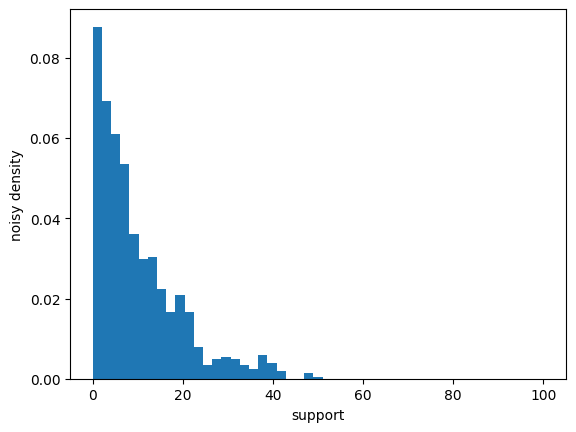

In [11]:
def make_distribution_counts(edges, scale):
    bin_names = [str(i) for i in range(len(edges - 1))]

    return (
        input_space >>
        dp.t.then_find_bin(edges=edges) >> # bin the data
        dp.t.then_index(bin_names, "0") >> # can be omitted. Just set TIA="usize", categories=list(range(num_bins)) on next line:
        dp.t.then_count_by_categories(categories=bin_names, null_category=False) >>
        dp.m.then_laplace(scale)
    )

edges = np.linspace(*bounds, num=50)
counts = make_distribution_counts(edges, scale=1.)(data)

import matplotlib.pyplot as plt

plt.hist(range(len(edges)), edges, weights=counts, density=True)
plt.xlabel("support")
plt.ylabel("noisy density");